# Dependency

In [351]:
import h5py
import os
import pickle

from tqdm import tqdm
from time import gmtime, strftime

import numpy as np
import math

from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import roc_curve

import tensorflow as tf
from tensorflow.keras import layers,Model

##

from sklearn.model_selection import KFold

import gc

import time
from sklearn.model_selection import KFold

import import_data_prottrans as load_data

# PARAM 


In [352]:
DATA_LABEL=load_data.data_label()

DATA_TYPE = "Prottrans"
#"/BinaryMatrix" "/MMseqs2" "/ProtTrans""/ESM-2""/TAPE"
#"20" "20" "1024" "1280""768"
MAXSEQ = 20
NUM_FEATURE = 1024

NUM_FILTER = 1024
NUM_HIDDEN = 500
BATCH_SIZE  = 512
WINDOW_SIZES = [2,4,8,10]

NUM_CLASSES = 2
CLASS_NAMES = ['Negative', 'Positive']


EPOCHS = 20
K_Fold = 5
VALIDATION_MODE="independent"
#"independent" "cross"

IMBALANCE="None"
#None
#SMOTE
#ADASYN
#RANDOM

# Time Log

In [353]:
import datetime

write_data=[]
a=datetime.datetime.now()
write_data.append(time.ctime())
write_data.append(DATA_LABEL)
write_data.append(DATA_TYPE)
write_data.append(BATCH_SIZE)
write_data.append(NUM_HIDDEN)
write_data.append(WINDOW_SIZES)
write_data.append(NUM_FILTER)
write_data.append(VALIDATION_MODE)
write_data.append(IMBALANCE)

#write_data.append(IMBLANCE)
#write_data.append(SHUFFLE)

In [354]:
def time_log(message):
    print(message," : ",strftime("%Y-%m-%d %H:%M:%S", gmtime()))

## PKL File

In [355]:
import os
import pickle
import time

def SAVEROC(fpr, tpr, AUC):
    data_to_save = {
        "fpr": fpr,
        "tpr": tpr,
        "AUC": AUC
    }

    # Use relative path
    folder = "./PKL/Feature/prollma/"
    os.makedirs(folder, exist_ok=True)  # create folder if it doesn't exist

    file_name = f"Prottrans_ProLLaMA_Independent_{int(time.time())}.pkl"
    file_path = os.path.join(folder, file_name)

    with open(file_path, "wb") as file:
        pickle.dump(data_to_save, file)

    print(f"ROC data saved to: {os.path.abspath(file_path)}")


In [356]:
"----------------------------------------------------------------------------------------------------"
# model fit batch funtion
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        return np.array(batch_data), np.array(batch_labels)
    
"----------------------------------------------------------------------------------------------------"

'----------------------------------------------------------------------------------------------------'

# MCNN

In [357]:
class DeepScan(Model):

	def __init__(self,
	             input_shape=(1, MAXSEQ, NUM_FEATURE),
	             window_sizes=[32],
	             num_filters=256,
	             num_hidden=1000):
		super(DeepScan, self).__init__()
		# Add input layer
		self.input_layer = tf.keras.Input(input_shape)
		self.window_sizes = window_sizes
		self.conv2d = []
		self.maxpool = []
		self.flatten = []
		for window_size in self.window_sizes:
			self.conv2d.append(
                layers.Conv2D(filters=num_filters,
    			              kernel_size=(1, window_size),
			                  activation=tf.nn.relu,
			                  padding='valid',
			                  bias_initializer=tf.constant_initializer(0.1),
			                  kernel_initializer=tf.keras.initializers.GlorotUniform()
                             )
                             )
			self.maxpool.append(
    			layers.MaxPooling2D(pool_size=(1, MAXSEQ - window_size + 1),
			                        strides=(1, MAXSEQ),
			                        padding='valid')
                               )
			self.flatten.append(layers.Flatten())
		self.dropout = layers.Dropout(rate=0.7)
		self.fc1 = layers.Dense(num_hidden,
                        		activation=tf.nn.relu,
		                        bias_initializer=tf.constant_initializer(0.1),
		                        kernel_initializer=tf.keras.initializers.GlorotUniform()
                               )
		self.fc2 = layers.Dense(NUM_CLASSES,
		                        activation='softmax',
		                        kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                               )
		self.out = self.call(self.input_layer)

	def call(self, x, training=False):
		_x = []
		for i in range(len(self.window_sizes)):
			x_conv = self.conv2d[i](x)
			x_maxp = self.maxpool[i](x_conv)
			x_flat = self.flatten[i](x_maxp)
			_x.append(x_flat)

		x = tf.concat(_x, 1)
		x = self.dropout(x, training=training)
		x = self.fc1(x)
		x = self.fc2(x) 
		return x

# Main

In [358]:
# Example usage:
x_train,y_train,x_test,y_test= load_data.MCNN_data_load(DATA_TYPE,MAXSEQ)

In [359]:
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(x_test.shape)
print(x_test.dtype)
print(y_test.shape)

(2764, 1, 20, 1024)
float16
(2764, 2)
(590, 1, 20, 1024)
float16
(590, 2)


# Imbalanced

In [360]:
def IMBALANCE_funct(IMBALANCE,x_train,y_train):
    if(IMBALANCE)=="None":
        return x_train,y_train
    else:
        from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler
    
        # 將 x_train 的形狀重新整形為二維
        x_train_2d = x_train.reshape(x_train.shape[0], -1)
        print(x_train_2d.shape)
        print(y_train.shape)
        #print(y_train.shape)
        # 創建 SMOTE 物件
        if IMBALANCE=="SMOTE":
            imbalance = SMOTE(random_state=42)
        elif IMBALANCE=="ADASYN":
            imbalance = ADASYN(random_state=42)
        elif IMBALANCE=="RANDOM":
            imbalance = RandomOverSampler(random_state=42)
        
    
        # 使用 fit_resample 進行過採樣
        x_train_resampled, y_train_resampled = imbalance.fit_resample(x_train_2d, y_train)
    
        # 將 x_train_resampled 的形狀恢復為四維
        x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 1, MAXSEQ, NUM_FEATURE)
    
        print(x_train_resampled.shape)
        print(y_train_resampled.shape)
    
        x_train=x_train_resampled
        y_train=y_train_resampled
        
        del x_train_resampled
        del y_train_resampled
        del x_train_2d
        gc.collect()
    
        import tensorflow as tf
        y_train = tf.keras.utils.to_categorical(y_train,NUM_CLASSES)
        return x_train,y_train

In [361]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2764, 1, 20, 1024)
(2764, 2)
(590, 1, 20, 1024)
(590, 2)


## Model Test

In [362]:
def model_test(model, x_test, y_test):

    print(x_test.shape)
    pred_test = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test[:,1], pred_test[:, 1])
    AUC = metrics.auc(fpr, tpr)
    #tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name='mCNN')
    display.plot()
    

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]

    y_pred = (pred_test[:, 1] >= threshold).astype(int)

    TN, FP, FN, TP =  metrics.confusion_matrix(y_test[0:][:,1], y_pred).ravel()

    Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
    Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
    Acc = (TP+TN)/(TP+FP+TN+FN)
    MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN and TN+FN else 0.0
    F1 = 2*TP/(2*TP+FP+FN)
    Prec=TP/(TP+FP)
    Recall=TP/(TP+FN)
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}\n')
    SAVEROC(fpr,tpr,AUC)
    
    return TP,FP,TN,FN,Sens,Spec,Acc,MCC,AUC

In [363]:
if(VALIDATION_MODE=="cross"):
	time_log("Start cross")
	
	kfold = KFold(n_splits = K_Fold, shuffle = True, random_state = 2)
	results=[]
	i=1
	for train_index, test_index in kfold.split(x_train):
		print(i,"/",K_Fold,'\n')
		# 取得訓練和測試數據
		X_train, X_test = x_train[train_index], x_train[test_index]
		Y_train, Y_test = y_train[train_index], y_train[test_index]
		
		print(X_train.shape)
		print(X_test.shape)
		print(Y_train.shape)
		print(Y_test.shape)
		X_train,Y_train=IMBALANCE_funct(IMBALANCE,X_train,Y_train)
		generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE)
		# 重新建模
		model = DeepScan(
		num_filters=NUM_FILTER,
			num_hidden=NUM_HIDDEN,
			window_sizes=WINDOW_SIZES)
		model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
		model.build(input_shape=X_train.shape)
		# 在測試數據上評估模型
		history=model.fit(
			generator,
			epochs=EPOCHS,
			callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
			verbose=1,
			shuffle=True
		)
		TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC = model_test(model, X_test, Y_test)
		results.append([TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC])
		i+=1
		
		del X_train
		del X_test
		del Y_train
		del Y_test
		gc.collect()
		
	mean_results = np.mean(results, axis=0)
	print(f'TP={mean_results[0]:.4}, FP={mean_results[1]:.4}, TN={mean_results[2]:.4}, FN={mean_results[3]:.4}, Sens={mean_results[4]:.4}, Spec={mean_results[5]:.4}, Acc={mean_results[6]:.4}, MCC={mean_results[7]:.4}, AUC={mean_results[8]:.4}\n')
	write_data.append(mean_results[0])
	write_data.append(mean_results[1])
	write_data.append(mean_results[2])
	write_data.append(mean_results[3])
	write_data.append(mean_results[4])
	write_data.append(mean_results[5])
	write_data.append(mean_results[6])
	write_data.append(mean_results[7])
	write_data.append(mean_results[8])

Start Model Train  :  2025-10-20 08:30:28
Model: "deep_scan_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_303 (Conv2D)         (None, 1, 19, 1024)       2098176   
                                                                 
 conv2d_304 (Conv2D)         (None, 1, 17, 1024)       4195328   
                                                                 
 conv2d_305 (Conv2D)         (None, 1, 13, 1024)       8389632   
                                                                 
 conv2d_306 (Conv2D)         (None, 1, 11, 1024)       10486784  
                                                                 
 max_pooling2d_303 (MaxPooli  (None, 1, 1, 1024)       0         
 ng2D)                                                           
                                                                 
 max_pooling2d_304 (MaxPooli  (None, 1, 1, 1024)       0         
 ng2D)      

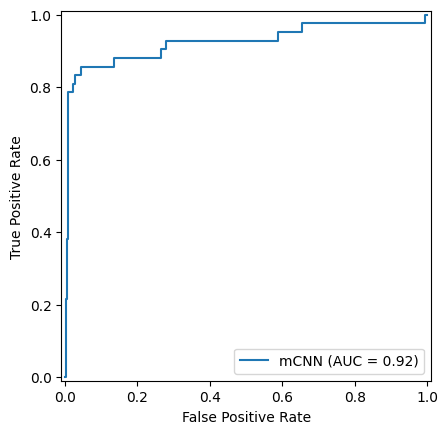

In [364]:
if(VALIDATION_MODE=="independent"):
    x_train,y_train=IMBALANCE_funct(IMBALANCE,x_train,y_train)
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
    time_log("Start Model Train")
    model = DeepScan(
    	num_filters=NUM_FILTER,
    	num_hidden=NUM_HIDDEN,
    	window_sizes=WINDOW_SIZES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()
    model.fit(
    	generator,
    	epochs=EPOCHS,
    	shuffle=True,
    )
    time_log("End Model Train")
    time_log("Start Model Test")
    TP,FP,TN,FN,Sens,Spec,Acc,MCC,AUC = model_test(model, x_test, y_test)
    write_data.append(TP)
    write_data.append(FP)
    write_data.append(TN)
    write_data.append(FN)
    write_data.append(Sens)
    write_data.append(Spec)
    write_data.append(Acc)
    write_data.append(MCC)
    write_data.append(AUC)
       
    time_log("End Model Test")



In [365]:
if(VALIDATION_MODE=="LOAD"):
    model = DeepScan(
    		num_filters=NUM_FILTER,
    		num_hidden=NUM_HIDDEN,
    		window_sizes=WINDOW_SIZES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()
    model.load_weights('my_model_weights.h5')
    
    time_log("End Model Train")
    time_log("Start Model Test")
    TP,FP,TN,FN,Sens,Spec,Acc,MCC,AUC = model_test(model, x_test, y_test)
    write_data.append(TP)
    write_data.append(FP)
    write_data.append(TN)
    write_data.append(FN)
    write_data.append(Sens)
    write_data.append(Spec)
    write_data.append(Acc)
    write_data.append(MCC)
    write_data.append(AUC)
        
    time_log("End Model Test")

In [366]:
def save_csv(write_data,a):
    import csv
    b=datetime.datetime.now()
    write_data.append(b-a)
    open_csv=open("C:/jupyter/juan/TNF/RESULT/TNF_ProLLaMA.csv","a")
    write_csv=csv.writer(open_csv)
    write_csv.writerow(write_data)
save_csv(write_data,a)

In [367]:
import os

# Ensure the directory exists
os.makedirs("./saved_weights/prollma", exist_ok=True)

# Save the model weights
model.save_weights(f"./saved_weights/prollma/Prottrans_PROLLMA_Model_MSCNN_{MAXSEQ}_{DATA_TYPE}_{WINDOW_SIZES}.h5")
print(f"Save model Model_MSCNN_{MAXSEQ}_{DATA_TYPE}_{WINDOW_SIZES}.h5 successfully!")


Save model Model_MSCNN_20_Prottrans_[2, 4, 8, 10].h5 successfully!
